# Assignment 3: Hopfield Networks


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
class HopfieldNetwork:
    def __init__(self):
        self.weights = None

    def train(self, patterns, check=False, asynchronous=False, max_iter=1):
        self.patterns = patterns

        # W = xT * x
        self.weights = np.sum([p.reshape((-1,1))*p.reshape((1,-1)) for p in patterns], axis=0).astype(np.float)

        # divide by number of units
        self.weights /= self.weights.shape[0]

        if check:
            patterns_to_learn = len(patterns)
            patterns_learnt = 0
            for pattern in patterns:
                output = self.recall(pattern, asynchronous, max_iter)
                if output.all() == pattern.all():
                    patterns_learnt += 1

            compare_array = output == pattern
            if compare_array.all():
                print("All", patterns_learnt, "patterns learnt." )
            else:
                print("Only", patterns_learnt, "patterns learnt." )

    
    def recall(self, pattern, asynchronous=False, max_iter=1, check_data=False, check_data_cycle=3):
        if not asynchronous:
            # print("Running Recall")
            output = np.sign(np.dot(pattern,self.weights))
            # takes care of zeros
            output[output == 0] = -1
            return output
        else:
            if not check_data:
                pattern_copy = pattern.copy()
                iter = 0
                while iter<max_iter:
                    # list of all the positions still left to update
                    self.positions_to_update = list(np.arange(0,pattern.shape[0],1))
                    # loop through W vectors on pattern appliying the change to the data
                    for i in range(0, pattern.shape[0]):
                        updated_pattern = self.asynchronous_update(pattern_copy)
                        pattern_copy = updated_pattern
                    
                    iter += 1
                return updated_pattern
            else:
                pattern_copy = pattern.copy()
                iter = 0
                while iter<max_iter:
                    # list of all the positions still left to update
                    self.positions_to_update = list(np.arange(0,pattern.shape[0],1))
                    # loop through W vectors on pattern appliying the change to the data
                    for i in range(0, check_data_cycle):
                        updated_pattern = self.asynchronous_update(pattern_copy)
                        pattern_copy = updated_pattern

                        if len(self.positions_to_update) == 0:
                            self.positions_to_update = list(np.arange(0,pattern.shape[0],1))

                    iter += 1
                return updated_pattern

    def asynchronous_update(self, pattern, seed=2020):
        np.random.seed(seed)
        j = np.random.choice(self.positions_to_update)

        output = np.sign(np.sum(self.weights[j,:]*pattern))

        # updated_pattern = output
        # print(updated_pattern)
        pattern[j] = 1.0 if output>0.0 else -1.0

        self.positions_to_update.remove(j)
        return pattern 

    def check_attractors(self, display_attractors=True):
        attractors = set()
        possibilities = len(self.patterns[0])

        for num in range(0, 2**possibilities):
            # Decimal to binary number list conversion and fill with zeros 
            binnum = np.array([int(i) for i in bin(num)[2:].zfill(possibilities)])
            
            # change all 0 to -1
            binnum[binnum == 0] = -1

            # add possible output to data
            output = self.recall(binnum, asynchronous=False)

            # print(output)
            attractors.add(str(output))
        
        if display_attractors == True:
            print(len(attractors),"attractors found. The attractors are:")
            for i in attractors:
                print(i)
            return attractors
        else: 
            print(len(attractors),"attractors found.")       
            return attractors

    def attractor_energy(self, attractor_state):
        temp = attractor_state.reshape((-1,1))*attractor_state.reshape((1,-1))
        return -np.sum(temp*self.weights)        


## Part 2- Preliminary

In [60]:
x1=[-1, -1, 1, -1, 1, -1, -1, 1]
x2=[-1, -1, -1, -1, -1, 1, -1, -1]
x3=[-1, 1, 1, -1, -1, 1, -1, 1]
training_patterns = np.array([x1,x2,x3])

hopfield_network_test = HopfieldNetwork()
hopfield_network_test.train(training_patterns, True, asynchronous=False)

All 3 patterns learnt.


## Part 3.1 Convergence and Attractors
Recall of stored patterns from distorted inputs?

In [61]:
def recall_test(distorted_pattern, expected_pattern, trained_network, asynchronous=False, max_iterations=100, check_data=False, check_data_cycle=1):
    output = trained_network.recall(distorted_pattern, asynchronous, max_iter=1, check_data=check_data, check_data_cycle=check_data_cycle)
    recall_iterations = 1

    compare_array = np.array([2]) == np.array([1])
    while not compare_array.all():
        compare_array = expected_pattern == output
        if compare_array.all():
            print("SUCCESS. \t", distorted_pattern, "->", output,"after", recall_iterations, "iterations.")
            print()
            break
        elif recall_iterations == max_iterations:
            print("FAILURE. \t", distorted_pattern, "!->", expected_pattern, "after", recall_iterations, "iterations." )
            # print("\t Final output was", output)
            print()
            break
        else:
            recall_iterations += 1
            output = trained_network.recall(output, asynchronous)

        # print("FAILURE. Input", distorted_pattern, "gives", output,".", expected_pattern, "was expected.")


### 3.1.1
Attempt at using trained network to converge distored inputs to learnt outputs.
Use the 2nd x1d to test with 5 differences.

In [62]:
x1d=np.array([ 1, -1, 1, -1, 1, -1, -1, 1])
x2d=np.array([ 1, 1, -1, -1, -1, 1, -1, -1])
x3d=np.array([ 1, 1, 1, -1, 1, 1, -1, 1])

recall_test(x1d, x1, hopfield_network_test, asynchronous=False, max_iterations=100)
recall_test(x2d, x2, hopfield_network_test, asynchronous=False, max_iterations=100)
recall_test(x3d, x3, hopfield_network_test, asynchronous=False, max_iterations=100)

SUCCESS. 	 [ 1 -1  1 -1  1 -1 -1  1] -> [-1. -1.  1. -1.  1. -1. -1.  1.] after 1 iterations.

SUCCESS. 	 [ 1  1 -1 -1 -1  1 -1 -1] -> [-1. -1. -1. -1. -1.  1. -1. -1.] after 2 iterations.

SUCCESS. 	 [ 1  1  1 -1  1  1 -1  1] -> [-1.  1.  1. -1. -1.  1. -1.  1.] after 2 iterations.



### 3.1.2 Check attractors.

In [63]:
attractors_for_3_1 = hopfield_network_test.check_attractors()

19 attractors found. The attractors are:
[ 1.  1.  1.  1.  1. -1.  1.  1.]
[-1. -1.  1. -1. -1.  1. -1.  1.]
[-1. -1.  1. -1. -1. -1. -1.  1.]
[-1.  1.  1. -1. -1. -1. -1.  1.]
[-1. -1. -1. -1. -1. -1. -1. -1.]
[-1. -1. -1. -1.  1. -1. -1. -1.]
[-1.  1.  1. -1.  1. -1. -1.  1.]
[-1. -1. -1. -1. -1.  1. -1. -1.]
[ 1.  1. -1.  1. -1. -1.  1. -1.]
[-1.  1. -1. -1. -1.  1. -1. -1.]
[ 1. -1. -1.  1.  1. -1.  1. -1.]
[ 1.  1.  1.  1. -1.  1.  1.  1.]
[ 1. -1. -1.  1. -1. -1.  1. -1.]
[-1. -1.  1. -1.  1. -1. -1.  1.]
[ 1.  1. -1.  1. -1.  1.  1. -1.]
[ 1.  1. -1.  1.  1. -1.  1. -1.]
[-1.  1.  1. -1. -1.  1. -1.  1.]
[ 1. -1.  1.  1.  1. -1.  1.  1.]
[ 1. -1. -1.  1. -1.  1.  1. -1.]


### 3.1.3 Use a very dissimlar pattern

With 5 different values, the networks was unable to converge to the first value.

In [64]:
x1d=np.array([ 1, -1, -1, 1, -1, -1, 1, 1])
recall_test(x1d, x1, hopfield_network_test, asynchronous=False, max_iterations=100)

FAILURE. 	 [ 1 -1 -1  1 -1 -1  1  1] !-> [-1, -1, 1, -1, 1, -1, -1, 1] after 100 iterations.



## Part 3.2- Sequential Update
This network will have 1024 neurons and be used on pictures. 
Load the data from pict.dat. There are 9 1024 dimension patterns. 

Generate Images

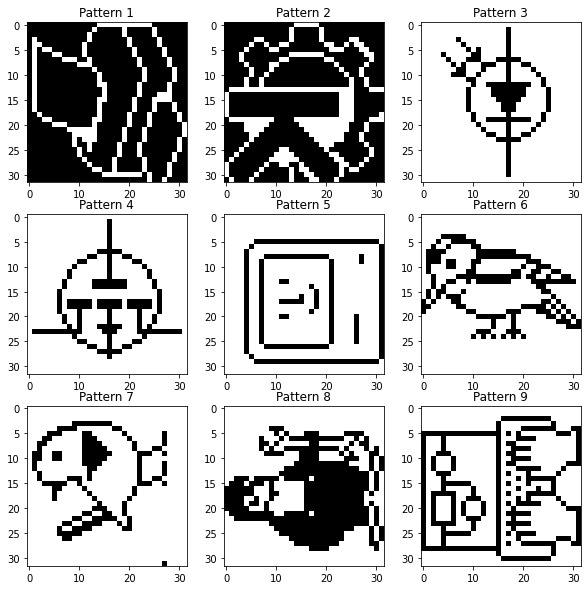

In [65]:
# load data with info in each column per image
pics = np.genfromtxt('pict.dat', delimiter=',').reshape(-1,1024)
fig = plt.figure(figsize=(10,10))
for i, pattern in enumerate(pics[:9,:]):
    fig.add_subplot(330 + i + 1)
    plt.imshow(pattern.reshape(32, 32), cmap='gray')
    plt.title("Pattern " + str(i+1))

In [66]:
def recall_image_test(distorted_pattern, expected_pattern, trained_network, asynchronous=False, max_iterations = 1, check_data=False, check_data_cycle=1):
    # fig = plt.figure(figsize=(10,10))

    # fig.add_subplot(331)
    # plt.imshow(distorted_pattern.reshape(32, 32), cmap='gray')
    # fig.add_subplot(332)

    output = trained_network.recall(distorted_pattern, asynchronous, max_iter=1, check_data=check_data, check_data_cycle=check_data_cycle)
    recall_iterations = 1

    compare_array = np.array([2]) == np.array([1])
    while not compare_array.all():
        compare_array = expected_pattern == output
        if compare_array.all():
            print("SUCCESS after", recall_iterations, "iterations.")
            print()
            return output
        elif recall_iterations == max_iterations:
            print("FAILURE after", recall_iterations, "iterations." )
            # print("\t Final output was", output)
            print()
            return output
        else:
            recall_iterations += 1
            output = output = trained_network.recall(distorted_pattern, asynchronous, max_iter=1, check_data=check_data, check_data_cycle=check_data_cycle)



### 3.1.1 Check if first 3 are stable
Train network then run recall network afterwards. 

In [123]:
p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11 = pics[0], pics[1], pics[2], pics[3], pics[4], pics[5], pics[6], pics[7], pics[8], pics[9], pics[10]

hopfield_network_pics = HopfieldNetwork()
hopfield_network_pics.train(pics[0:3], True, asynchronous=True, max_iter=1)

All 3 patterns learnt.


In [124]:
pic1_stability_check = recall_image_test(p1, p1, hopfield_network_pics, asynchronous=True, max_iterations = 1)
pic2_stability_check = recall_image_test(p2, p2, hopfield_network_pics, asynchronous=True, max_iterations = 1)
pic3_stability_check = recall_image_test(p3, p3, hopfield_network_pics, asynchronous=True, max_iterations = 1)

# pic4_stability_check = recall_image_test(p4, p4, hopfield_network_pics, asynchronous=True, max_iterations = 1)

SUCCESS after 1 iterations.

SUCCESS after 1 iterations.

SUCCESS after 1 iterations.



Check p1,p2,p3 on the network.

Text(0.5, 1.0, 'Pattern 3')

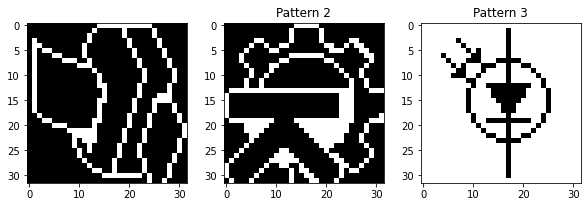

In [125]:
fig = plt.figure(figsize=(10,10))

fig.add_subplot(331)
plt.imshow(pic1_stability_check.reshape(32, 32), cmap='gray')
fig.add_subplot(332)
plt.imshow(pic2_stability_check.reshape(32, 32), cmap='gray')
plt.title("Pattern 2")
fig.add_subplot(333)
plt.imshow(pic3_stability_check.reshape(32, 32), cmap='gray')
plt.title("Pattern 3")

# fig.add_subplot(334)
# plt.imshow(pic4_stability_check.reshape(32, 32), cmap='gray')
# plt.title("Pattern 4")

### 3.2.2 Check Degraded patterns
check synchronous and asynchronous networks

In [70]:
pic1_degraded = recall_image_test(p10, p1, hopfield_network_pics, asynchronous=False, max_iterations = 1)
pic2_degraded = recall_image_test(p11, p2, hopfield_network_pics, asynchronous=False, max_iterations = 1)
pic3_degraded = recall_image_test(p11, p3, hopfield_network_pics, asynchronous=False, max_iterations = 1)


SUCCESS after 1 iterations.

FAILURE after 1 iterations.

FAILURE after 1 iterations.



Text(0.5, 1.0, 'After Network')

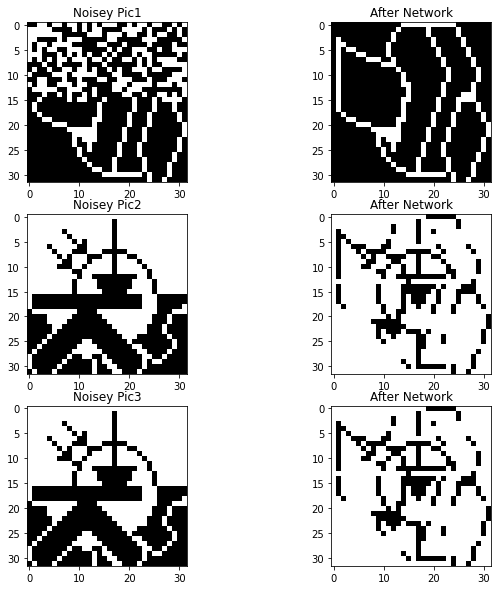

In [71]:
fig = plt.figure(figsize=(10,10))

fig.add_subplot(321)
plt.imshow(p10.reshape(32, 32), cmap='gray')
plt.title("Noisey Pic1")
fig.add_subplot(322)
plt.imshow(pic1_degraded.reshape(32, 32), cmap='gray')
plt.title("After Network")

fig.add_subplot(323)
plt.imshow(p11.reshape(32, 32), cmap='gray')
plt.title("Noisey Pic2")
fig.add_subplot(324)
plt.imshow(pic2_degraded.reshape(32, 32), cmap='gray')
plt.title("After Network")

fig.add_subplot(325)
plt.imshow(p11.reshape(32, 32), cmap='gray')
plt.title("Noisey Pic3")
fig.add_subplot(326)
plt.imshow(pic3_degraded.reshape(32, 32), cmap='gray')
plt.title("After Network")

SUCCESS after 1 iterations.

FAILURE after 1 iterations.

FAILURE after 1 iterations.



Text(0.5, 1.0, 'After Network')

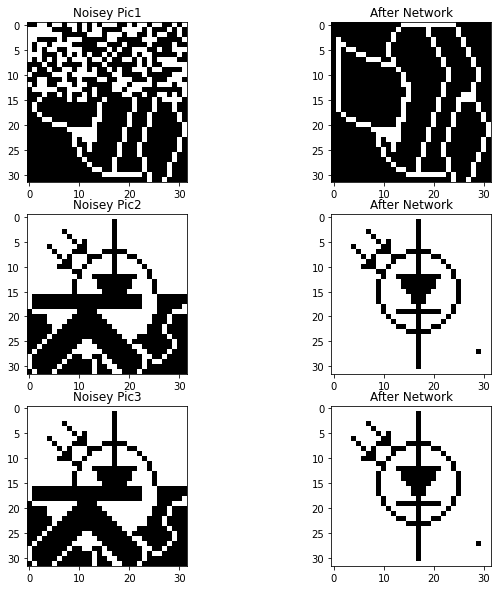

In [72]:
pic1_degraded = recall_image_test(p10, p1, hopfield_network_pics, asynchronous=True, max_iterations = 1)
pic2_degraded = recall_image_test(p11, p2, hopfield_network_pics, asynchronous=True, max_iterations = 1)
pic3_degraded = recall_image_test(p11, p3, hopfield_network_pics, asynchronous=True, max_iterations = 1)

fig = plt.figure(figsize=(10,10))

fig.add_subplot(321)
plt.imshow(p10.reshape(32, 32), cmap='gray')
plt.title("Noisey Pic1")
fig.add_subplot(322)
plt.imshow(pic1_degraded.reshape(32, 32), cmap='gray')
plt.title("After Network")

fig.add_subplot(323)
plt.imshow(p11.reshape(32, 32), cmap='gray')
plt.title("Noisey Pic2")
fig.add_subplot(324)
plt.imshow(pic2_degraded.reshape(32, 32), cmap='gray')
plt.title("After Network")

fig.add_subplot(325)
plt.imshow(p11.reshape(32, 32), cmap='gray')
plt.title("Noisey Pic3")
fig.add_subplot(326)
plt.imshow(pic3_degraded.reshape(32, 32), cmap='gray')
plt.title("After Network")

### 3.2.3 Random Selection

In [73]:
pic1_degraded_100 = hopfield_network_pics.recall(p10, asynchronous=True, max_iter=1, check_data=True, check_data_cycle=100)
pic1_degraded_400 = hopfield_network_pics.recall(p10, asynchronous=True, max_iter=1, check_data=True, check_data_cycle=400)
pic1_degraded_700 = hopfield_network_pics.recall(p10, asynchronous=True, max_iter=1, check_data=True, check_data_cycle=700)
pic1_degraded_1000 = hopfield_network_pics.recall(p10, asynchronous=True, max_iter=1, check_data=True, check_data_cycle=1000)
pic1_degraded_1024 = hopfield_network_pics.recall(p10, asynchronous=True, max_iter=1, check_data=True, check_data_cycle=1024)


Text(0.5, 1.0, 'After 1024')

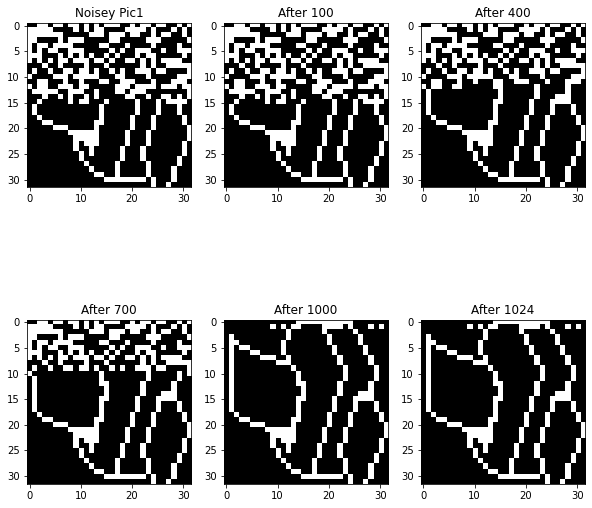

In [74]:
# np.shape(pic1_degraded_every_100)

fig = plt.figure(figsize=(10,10))

fig.add_subplot(231)
plt.imshow(p10.reshape(32, 32), cmap='gray')
plt.title("Noisey Pic1")
fig.add_subplot(232)
plt.imshow(pic1_degraded_100.reshape(32, 32), cmap='gray')
plt.title("After 100")
fig.add_subplot(233)
plt.imshow(pic1_degraded_400.reshape(32, 32), cmap='gray')
plt.title("After 400")
fig.add_subplot(234)
plt.imshow(pic1_degraded_700.reshape(32, 32), cmap='gray')
plt.title("After 700")
fig.add_subplot(235)
plt.imshow(pic1_degraded_1000.reshape(32, 32), cmap='gray')
plt.title("After 1000")
fig.add_subplot(236)
plt.imshow(pic1_degraded_1000.reshape(32, 32), cmap='gray')
plt.title("After 1024")

## 3.3 Energy
### 3.3.1 Energy of the different attractors

In [75]:
for attractor in attractors_for_3_1:
    state = []
    for a in attractor.split(" "):
        # print(a)
        if a == "1." or a == "-1.":
            state.append(float(a))
        elif a == "1.]" or a == "-1.]":
            state.append(float(a[0:2]))
        elif a == "[1." or a == "[-1.":
            state.append(float(a[1:3]))

    energy = hopfield_network_test.attractor_energy(np.array(state))
    print(attractor, "has energy",energy)

[ 1.  1.  1.  1.  1. -1.  1.  1.] has energy -8.5
[-1. -1.  1. -1. -1.  1. -1.  1.] has energy -8.5
[-1. -1.  1. -1. -1. -1. -1.  1.] has energy -7.0
[-1.  1.  1. -1. -1. -1. -1.  1.] has energy -6.5
[-1. -1. -1. -1. -1. -1. -1. -1.] has energy -5.0
[-1. -1. -1. -1.  1. -1. -1. -1.] has energy -4.5
[-1.  1.  1. -1.  1. -1. -1.  1.] has energy -7.0
[-1. -1. -1. -1. -1.  1. -1. -1.] has energy -8.5
[ 1.  1. -1.  1. -1. -1.  1. -1.] has energy -7.0
[-1.  1. -1. -1. -1.  1. -1. -1.] has energy -7.0
[ 1. -1. -1.  1.  1. -1.  1. -1.] has energy -9.0
[ 1.  1.  1.  1. -1.  1.  1.  1.] has energy -4.5
[ 1. -1. -1.  1. -1. -1.  1. -1.] has energy -6.5
[-1. -1.  1. -1.  1. -1. -1.  1.] has energy -8.5
[ 1.  1. -1.  1. -1.  1.  1. -1.] has energy -8.5
[ 1.  1. -1.  1.  1. -1.  1. -1.] has energy -8.5
[-1.  1.  1. -1. -1.  1. -1.  1.] has energy -9.0
[ 1. -1.  1.  1.  1. -1.  1.  1.] has energy -7.0
[ 1. -1. -1.  1. -1.  1.  1. -1.] has energy -7.0


Text(0.5, 1.0, 'Pic3 with Energy: -1462.25')

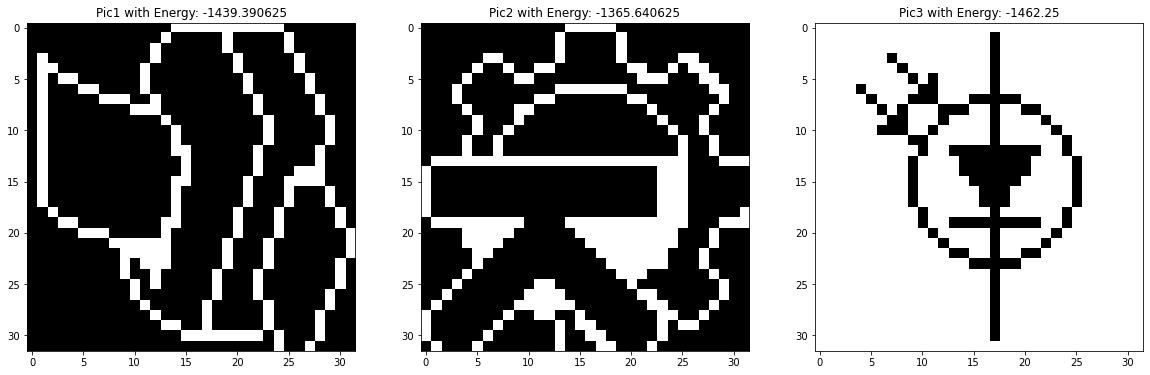

In [76]:
p1_energy = hopfield_network_pics.attractor_energy(p1)
p2_energy = hopfield_network_pics.attractor_energy(p2)
p3_energy = hopfield_network_pics.attractor_energy(p3)

fig = plt.figure(figsize=(20,20))

fig.add_subplot(131)
plt.imshow(p1.reshape(32, 32), cmap='gray')
plt.title("Pic1 with Energy: "+str(p1_energy))
fig.add_subplot(132)
plt.imshow(p2.reshape(32, 32), cmap='gray')
plt.title("Pic2 with Energy: "+str(p2_energy))
fig.add_subplot(133)
plt.imshow(p3.reshape(32, 32), cmap='gray')
plt.title("Pic3 with Energy: "+str(p3_energy))

### 3.3.2 Energy of the distorted points

In [77]:
energy = hopfield_network_test.attractor_energy(np.array(x1d))
print(attractor, "has energy",energy)
energy = hopfield_network_test.attractor_energy(np.array(x2d))
print(attractor, "has energy",energy)
energy = hopfield_network_test.attractor_energy(np.array(x3d))
print(attractor, "has energy",energy)

[ 1. -1. -1.  1. -1.  1.  1. -1.] has energy -3.0
[ 1. -1. -1.  1. -1.  1.  1. -1.] has energy -4.5
[ 1. -1. -1.  1. -1.  1.  1. -1.] has energy -3.0


Text(0.5, 1.0, 'Pic11 with Energy: -173.5')

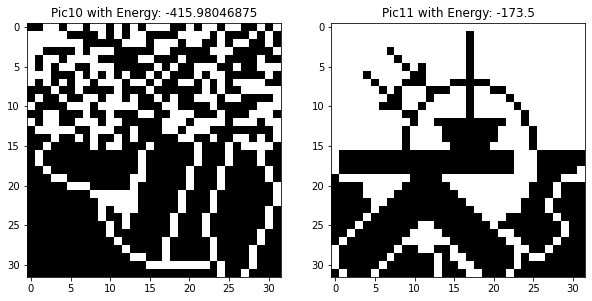

In [78]:
p10_energy = hopfield_network_pics.attractor_energy(p10)
p11_energy = hopfield_network_pics.attractor_energy(p11)

fig = plt.figure(figsize=(10,10))

fig.add_subplot(121)
plt.imshow(p10.reshape(32, 32), cmap='gray')
plt.title("Pic10 with Energy: "+str(p10_energy))
fig.add_subplot(122)
plt.imshow(p11.reshape(32, 32), cmap='gray')
plt.title("Pic11 with Energy: "+str(p11_energy))

### 3.3.3 Follow the energy for the sequntial update rule
First look at p1 then at x1d

Text(0.5, 1.0, 'Energy @ 1024: -1439.39')

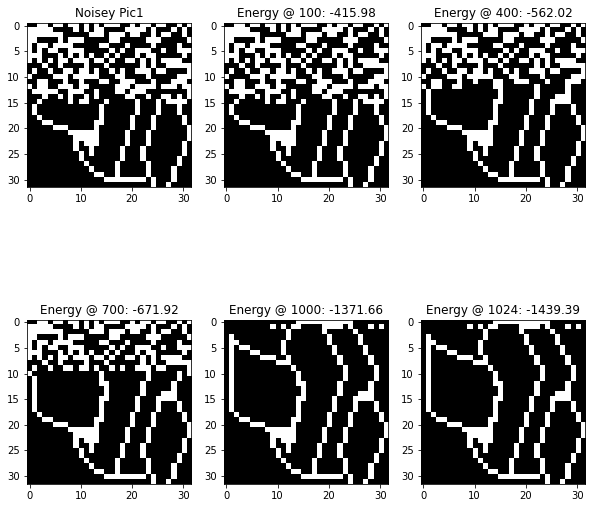

In [79]:
degraded_energy_100 = hopfield_network_pics.attractor_energy(pic1_degraded_100)
degraded_energy_400 = hopfield_network_pics.attractor_energy(pic1_degraded_400)
degraded_energy_700 = hopfield_network_pics.attractor_energy(pic1_degraded_700)
degraded_energy_1000 = hopfield_network_pics.attractor_energy(pic1_degraded_1000)
degraded_energy_1024 = hopfield_network_pics.attractor_energy(pic1_degraded_1024)


fig = plt.figure(figsize=(10,10))

fig.add_subplot(231)
plt.imshow(p10.reshape(32, 32), cmap='gray')
plt.title("Noisey Pic1")
fig.add_subplot(232)
plt.imshow(pic1_degraded_100.reshape(32, 32), cmap='gray')
plt.title("Energy @ 100: "+str(round(degraded_energy_100,2)))
fig.add_subplot(233)
plt.imshow(pic1_degraded_400.reshape(32, 32), cmap='gray')
plt.title("Energy @ 400: "+str(round(degraded_energy_400,2)))
fig.add_subplot(234)
plt.imshow(pic1_degraded_700.reshape(32, 32), cmap='gray')
plt.title("Energy @ 700: "+str(round(degraded_energy_700,2)))
fig.add_subplot(235)
plt.imshow(pic1_degraded_1000.reshape(32, 32), cmap='gray')
plt.title("Energy @ 1000: "+str(round(degraded_energy_1000,2)))
fig.add_subplot(236)
plt.imshow(pic1_degraded_1000.reshape(32, 32), cmap='gray')
plt.title("Energy @ 1024: "+str(round(degraded_energy_1024,2)))

In [80]:
energies_p10 = []
for i in range(1,200):
    pic1_degraded = hopfield_network_pics.recall(p10, asynchronous=True, max_iter=1, check_data=True, check_data_cycle=10*i)

    energy = hopfield_network_pics.attractor_energy(pic1_degraded)
    energies_p10.append(energy)

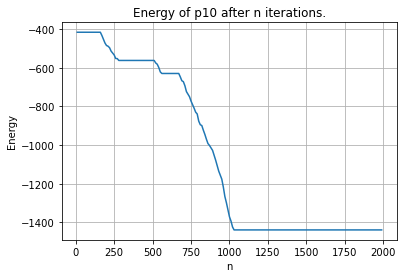

In [81]:
plt.figure()
plt.plot(np.arange(1,200,1)*10,energies_p10)
# plt.xticks(np.arange(0, 1100, 100))
# plt.yticks(np.arange(-1300, -300, 100))
plt.ylabel("Energy")
plt.xlabel("n")
plt.title("Energy of p10 after n iterations.")
plt.grid()
plt.show()

In [82]:
# x1d=np.array([ 1, -1, 1, -1, 1, -1, -1, 1])
# x2d=np.array([ 1, 1, -1, -1, -1, 1, -1, -1])
# x3d=np.array([ 1, 1, 1, -1, 1, 1, -1, 1])

bit_test = np.array([ -1, -1, -1, 1, -1, -1, 1, 1])
bit_energies = []
for i in range(1,19):
    output = hopfield_network_test.recall(bit_test, asynchronous=True, max_iter=1, check_data=True, check_data_cycle=i)

    energy = hopfield_network_test.attractor_energy(output)
    bit_energies.append(energy)

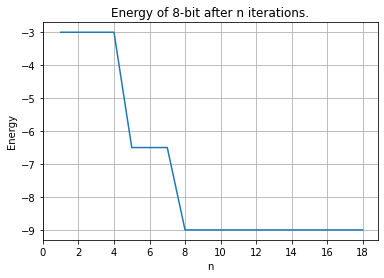

In [83]:
plt.figure()
plt.plot(np.arange(1,19,1),bit_energies)
plt.xticks(np.arange(0, 20, 2))
# plt.yticks(np.arange(-1300, -300, 100))
plt.ylabel("Energy")
plt.xlabel("n")
plt.title("Energy of 8-bit after n iterations.")
plt.grid()
plt.show()

### 3.3.3 Arbitary State

Start with a random weight matrix (not symmetric).
- It seems like all the images settle on an all black image which could be a local minima in the new network wuth the new weights?


In [86]:
np.random.seed(9000)
old_weights = hopfield_network_pics.weights
# print(hopfield_network_pics.weights[10])
weights = np.random.rand(1024,1024)/100
hopfield_network_pics.weights = weights
# print(hopfield_network_pics.weights[0])

energies_p1 = []
for i in range(1,200):
    pic1_degraded = hopfield_network_pics.recall(p1, asynchronous=True, max_iter=1, check_data=True, check_data_cycle=i*10)

    energy = hopfield_network_pics.attractor_energy(pic1_degraded)

    energies_p1.append(energy)

hopfield_network_pics.weights = old_weights

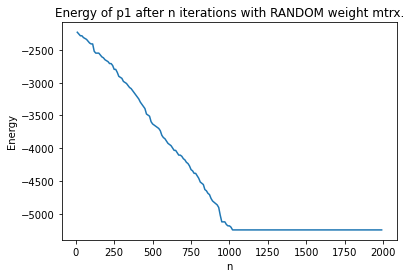

In [87]:
plt.figure()
plt.plot(np.arange(1,200,1)*10,energies_p1)
# plt.xticks(np.arange(0, 1100, 100))
# plt.yticks(np.arange(-1300, -300, 100))
plt.ylabel("Energy")
plt.xlabel("n")
plt.title("Energy of p1 after n iterations with RANDOM weight mtrx.")
plt.show()

Text(0.5, 1.0, 'p1 from random weights')

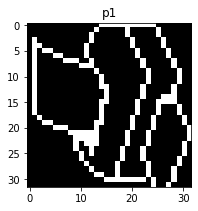

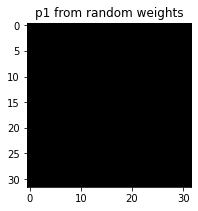

In [40]:
fig = plt.figure(figsize=(10,10))

fig.add_subplot(231)
plt.imshow(p1.reshape(32, 32), cmap='gray')
plt.title("p1")
fig = plt.figure(figsize=(10,10))

fig.add_subplot(231)
plt.imshow(pic1_degraded.reshape(32, 32), cmap='gray')
plt.title("p1 from random weights")

Start with a symmetric random weight matrix.

In [41]:
old_weights = hopfield_network_pics.weights
hopfield_network_pics.weights = 0.5*(weights+weights.T)

energies_p10 = []
for i in range(1,200):
    pic1_degraded = hopfield_network_pics.recall(p1, asynchronous=True, max_iter=1, check_data=True, check_data_cycle=10*i)

    energy = hopfield_network_pics.attractor_energy(pic1_degraded)
    energies_p10.append(energy)

hopfield_network_pics.weights = old_weights

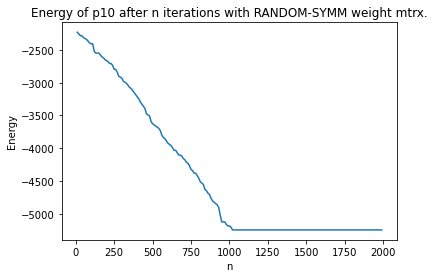

In [42]:
plt.figure()
plt.plot(np.arange(1,200,1)*10,energies_p10)
# plt.xticks(np.arange(0, 1100, 100))
# plt.yticks(np.arange(-1300, -300, 100))
plt.ylabel("Energy")
plt.xlabel("n")
plt.title("Energy of p10 after n iterations with RANDOM-SYMM weight mtrx.")
plt.show()

Text(0.5, 1.0, 'p1 from random weights')

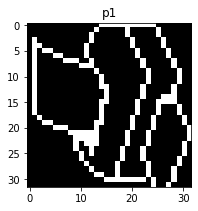

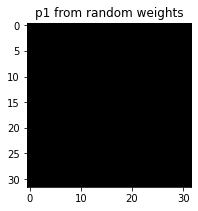

In [43]:
fig = plt.figure(figsize=(10,10))

fig.add_subplot(231)
plt.imshow(p1.reshape(32, 32), cmap='gray')
plt.title("p1")
fig = plt.figure(figsize=(10,10))

fig.add_subplot(231)
plt.imshow(pic1_degraded.reshape(32, 32), cmap='gray')
plt.title("p1 from random weights")

## 3.4 Distortion Resistance

Check that the networks are still intact
- __Note__: I think the output switches to an "inverted" attractor- hence the same image, but different bit output.
- Testing this (abs(distorted_pattern-pattern)) should give a vector of 2's
- __Note__: Where the energy curve is flat, indicates an attractor 

SUCCESS. 	 [-1, -1, 1, -1, 1, -1, -1, 1] -> [-1. -1.  1. -1.  1. -1. -1.  1.] after 1 iterations.

SUCCESS. 	 [-1, -1, -1, -1, -1, 1, -1, -1] -> [-1. -1. -1. -1. -1.  1. -1. -1.] after 1 iterations.

SUCCESS. 	 [-1, 1, 1, -1, -1, 1, -1, 1] -> [-1.  1.  1. -1. -1.  1. -1.  1.] after 1 iterations.

_____IMAGE TESTS_____

SUCCESS after 1 iterations.

SUCCESS after 1 iterations.

SUCCESS after 1 iterations.



Text(0.5, 1.0, 'Pattern 3')

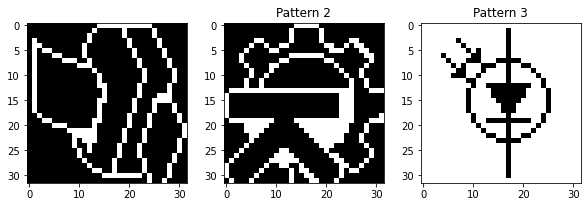

In [88]:
recall_test(x1, x1, hopfield_network_test, asynchronous=False, max_iterations=100)
recall_test(x2, x2, hopfield_network_test, asynchronous=False, max_iterations=100)
recall_test(x3, x3, hopfield_network_test, asynchronous=False, max_iterations=100)

print("_____IMAGE TESTS_____")
print()
pic1_stability_check = recall_image_test(p1, p1, hopfield_network_pics, asynchronous=False, max_iterations = 1)
pic2_stability_check = recall_image_test(p2, p2, hopfield_network_pics, asynchronous=False, max_iterations = 1)
pic3_stability_check = recall_image_test(p3, p3, hopfield_network_pics, asynchronous=False, max_iterations = 1)

fig = plt.figure(figsize=(10,10))
fig.add_subplot(331)
plt.imshow(pic1_stability_check.reshape(32, 32), cmap='gray')
fig.add_subplot(332)
plt.imshow(pic2_stability_check.reshape(32, 32), cmap='gray')
plt.title("Pattern 2")
fig.add_subplot(333)
plt.imshow(pic3_stability_check.reshape(32, 32), cmap='gray')
plt.title("Pattern 3")

Function for recall X amount of times

In [89]:
def distortion_resistance_recall(distorted_pattern, trained_network, max_iterations=10):
    i = 0
    while i < max_iterations:
        output = trained_network.recall(distorted_pattern)
        distorted_pattern = output
        i += 1
    
    return output

Function to test distortion and get patterns/ energies out

In [90]:
def test_distortion(pattern, trained_network, max_iterations=10):
    energies = []
    distorted_pattern = pattern.copy()
    np.random.seed(0)
    idx = np.arange(0,len(pattern),1)
    np.random.shuffle(idx)

    pattern_lst = []
    number_incorrect_percentage = [] 
    temp = False
    # swap one digit per iteration
    # calc energy per swap
    for i in idx:
        distorted_pattern[i] = pattern[i]*(-1)
        # differences.append(0.5*sum((abs(distorted_pattern-pattern))))
    
        distortion_output = distortion_resistance_recall(distorted_pattern, trained_network,max_iterations=10)

        energy = trained_network.attractor_energy(distortion_output)
        energies.append(energy)

        number_incorrect = sum( abs(np.array(pattern)-np.array(distortion_output)))/2
        number_incorrect_percentage.append((number_incorrect/len(pattern))*100)

        pattern_lst.append(pattern)
        # print(energy)

        if len(energies) > 1:
            if energies[-1] != energies[-2] and temp == False:
                first_offender = len(energies)-1
                temp = True

    
    return number_incorrect_percentage, energies, first_offender



Test bit network: This possibley identifies another attractor when the energy decreases

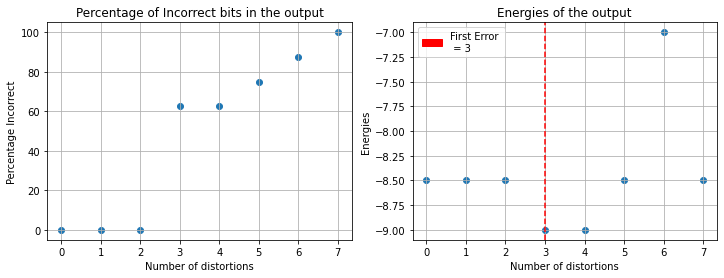

In [110]:
incorrect_percentages, energies, i = test_distortion(x1, hopfield_network_test, max_iterations=1)

fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)
plt.scatter(np.arange(0,len(x1),1), incorrect_percentages)
plt.ylabel("Percentage Incorrect")
plt.xlabel("Number of distortions")
plt.title("Percentage of Incorrect bits in the output")
plt.grid()

fig.add_subplot(122)
plt.scatter(np.arange(0,len(x1),1), energies)
plt.axvline(i, color='r', linestyle='--')
plt.ylabel("Energies")
plt.xlabel("Number of distortions")
plt.title("Energies of the output")
red = mpatches.Patch(color='red', label='First Error \n = {}'.format(i))
plt.legend(handles=[red]) 
plt.grid()
plt.show()

p1, p2 p3 image distortion checks

In [92]:
p1_incorrect_percentages, p1_energies, p1_i = test_distortion(p1, hopfield_network_pics, max_iterations=1)

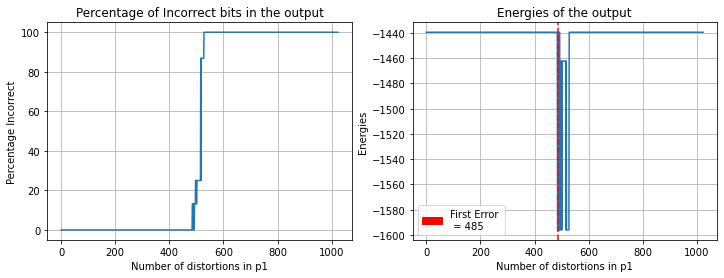

In [111]:
fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)
plt.plot(np.arange(0,len(p1),1), p1_incorrect_percentages)
plt.ylabel("Percentage Incorrect")
plt.xlabel("Number of distortions in p1")
plt.title("Percentage of Incorrect bits in the output")
plt.grid()

fig.add_subplot(122)
plt.plot(np.arange(0,len(p1),1), p1_energies)
plt.axvline(p1_i, color='r', linestyle='--')
plt.ylabel("Energies")
plt.xlabel("Number of distortions in p1")
plt.title("Energies of the output")
red = mpatches.Patch(color='red', label='First Error \n = {}'.format(p1_i))
plt.legend(handles=[red]) 
plt.grid()
plt.show()

# fig.add_subplot(332)
# plt.imshow(p.reshape(32, 32), cmap='gray')
# plt.title("Pattern 2")

# fig.add_subplot(333)
# plt.imshow(pic3_stability_check.reshape(32, 32), cmap='gray')
# plt.title("Pattern 3")

In [94]:
p2_incorrect_percentages,p2_energies, p2_i = test_distortion(p2, hopfield_network_pics, max_iterations=1)

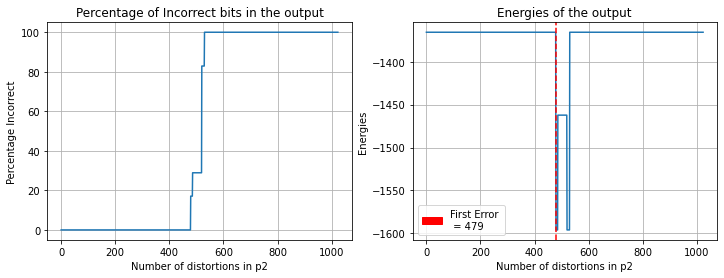

In [112]:
fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)
plt.plot(np.arange(0,len(p2),1), p2_incorrect_percentages)
plt.ylabel("Percentage Incorrect")
plt.xlabel("Number of distortions in p2")
plt.title("Percentage of Incorrect bits in the output")
plt.grid()

fig.add_subplot(122)
plt.plot(np.arange(0,len(p1),1), p2_energies)
plt.axvline(p2_i, color='r', linestyle='--')
plt.ylabel("Energies")
plt.xlabel("Number of distortions in p2")
plt.title("Energies of the output")
red = mpatches.Patch(color='red', label='First Error \n = {}'.format(p2_i))
plt.legend(handles=[red]) 
plt.grid()
plt.show()

In [98]:
p3_incorrect_percentages, p3_energies, p3_i = test_distortion(p3, hopfield_network_pics, max_iterations=1)


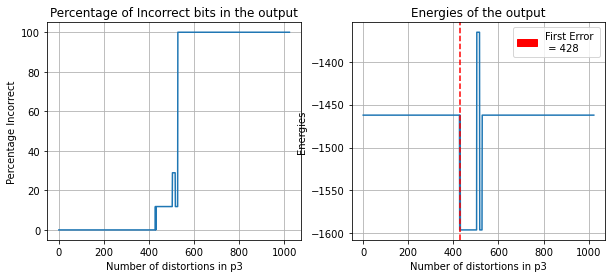

In [113]:
fig = plt.figure(figsize=(10,4))
fig.add_subplot(121)
plt.plot(np.arange(0,len(p3),1), p3_incorrect_percentages)
plt.ylabel("Percentage Incorrect")
plt.xlabel("Number of distortions in p3")
plt.title("Percentage of Incorrect bits in the output")
plt.grid()

fig.add_subplot(122)
plt.plot(np.arange(0,len(p3),1), p3_energies)
plt.axvline(p3_i, color='r', linestyle='--')
plt.ylabel("Energies")
plt.xlabel("Number of distortions in p3")
plt.title("Energies of the output")
red = mpatches.Patch(color='red', label='First Error \n = {}'.format(p3_i))
plt.legend(handles=[red]) 
plt.grid()
plt.show()

## 3.5 Capacity
Now add more and more memories to the network to see where the limit is. Start by adding p4 into the weight matrix and check if moderately distorted patters can still be recognized. Then continue by adding others such as and p7 p5 , p6 in some order and checking the performance after each addition.

Here we will add more images to the network and check the capacity. We do this by addding images to the network and checking if the above stuff still works.
- The change is abrupt, at 4 pics the identified attractors are incorrect so the network can not remember any attarctor correcly, thus the enrgies for the distortion recall are incorrect. 

- __Note__: Capacity depends on 0.138N, where N is the number of units (dependent on vector size here). However, with a larger vector size there are also more attractors, so the capacity is kind of a give and take. Maybe check for every bit added how many more attractors are added, while N will only increase by 1, so the capacity by 0.138? Will need 7.2 bits to increase the capacity by 1? But how does this relate to the first problem where capacity = at least 3 and there are many attractors, but N = 8?

### Test with 4 pics

Only 4 patterns learnt.
FAILURE after 1 iterations.

FAILURE after 1 iterations.

FAILURE after 1 iterations.

FAILURE after 1 iterations.



Text(0.5, 1.0, 'Pattern 4')

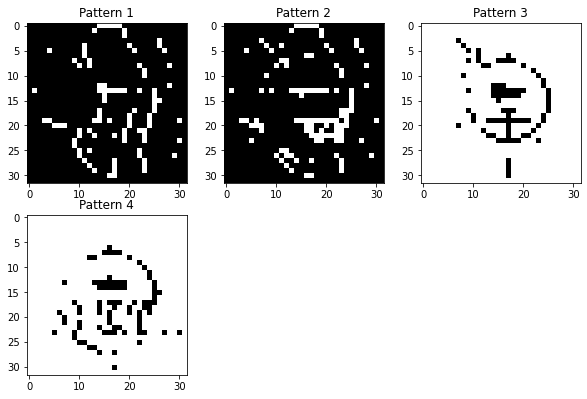

In [126]:
hopfield_network_pics.train(pics[0:4], True, asynchronous=True, max_iter=1)

pic1_stability_check = recall_image_test(p1, p1, hopfield_network_pics, asynchronous=True, max_iterations = 1)
pic2_stability_check = recall_image_test(p2, p2, hopfield_network_pics, asynchronous=True, max_iterations = 1)
pic3_stability_check = recall_image_test(p3, p3, hopfield_network_pics, asynchronous=True, max_iterations = 1)
pic4_stability_check = recall_image_test(p4, p4, hopfield_network_pics, asynchronous=True, max_iterations = 1)

fig = plt.figure(figsize=(10,10))

fig.add_subplot(331)
plt.imshow(pic1_stability_check.reshape(32, 32), cmap='gray')
plt.title("Pattern 1")
fig.add_subplot(332)
plt.imshow(pic2_stability_check.reshape(32, 32), cmap='gray')
plt.title("Pattern 2")
fig.add_subplot(333)
plt.imshow(pic3_stability_check.reshape(32, 32), cmap='gray')
plt.title("Pattern 3")
fig.add_subplot(334)
plt.imshow(pic4_stability_check.reshape(32, 32), cmap='gray')
plt.title("Pattern 4")

In [127]:
p1_incorrect_percentages, p1_energies, p1_i = test_distortion(p1, hopfield_network_pics, max_iterations=1)

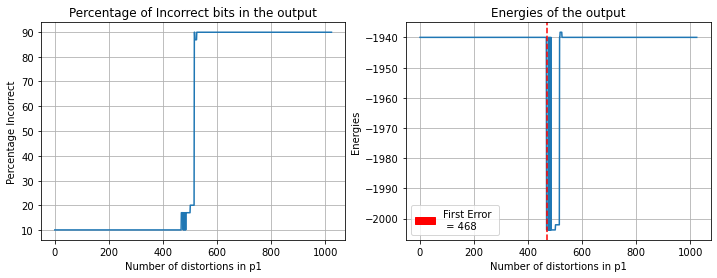

In [128]:
fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)
plt.plot(np.arange(0,len(p1),1), p1_incorrect_percentages)
plt.ylabel("Percentage Incorrect")
plt.xlabel("Number of distortions in p1")
plt.title("Percentage of Incorrect bits in the output")
plt.grid()

fig.add_subplot(122)
plt.plot(np.arange(0,len(p1),1), p1_energies)
plt.axvline(p1_i, color='r', linestyle='--')
plt.ylabel("Energies")
plt.xlabel("Number of distortions in p1")
plt.title("Energies of the output")
red = mpatches.Patch(color='red', label='First Error \n = {}'.format(p1_i))
plt.legend(handles=[red]) 
plt.grid()
plt.show()

In [129]:
p2_incorrect_percentages,p2_energies, p2_i = test_distortion(p2, hopfield_network_pics, max_iterations=1)

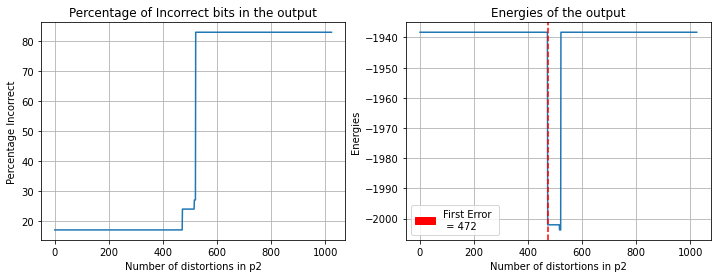

In [130]:
fig = plt.figure(figsize=(12,4))
fig.add_subplot(121)
plt.plot(np.arange(0,len(p2),1), p2_incorrect_percentages)
plt.ylabel("Percentage Incorrect")
plt.xlabel("Number of distortions in p2")
plt.title("Percentage of Incorrect bits in the output")
plt.grid()

fig.add_subplot(122)
plt.plot(np.arange(0,len(p1),1), p2_energies)
plt.axvline(p2_i, color='r', linestyle='--')
plt.ylabel("Energies")
plt.xlabel("Number of distortions in p2")
plt.title("Energies of the output")
red = mpatches.Patch(color='red', label='First Error \n = {}'.format(p2_i))
plt.legend(handles=[red]) 
plt.grid()
plt.show()

In [131]:
p3_incorrect_percentages, p3_energies, p3_i = test_distortion(p3, hopfield_network_pics, max_iterations=1)


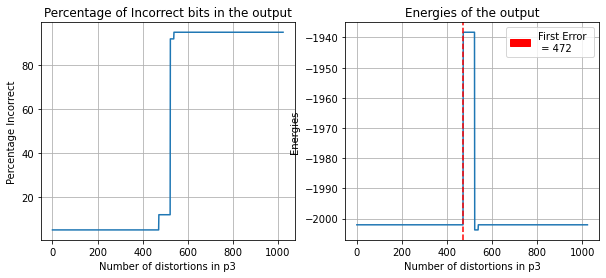

In [132]:
fig = plt.figure(figsize=(10,4))
fig.add_subplot(121)
plt.plot(np.arange(0,len(p3),1), p3_incorrect_percentages)
plt.ylabel("Percentage Incorrect")
plt.xlabel("Number of distortions in p3")
plt.title("Percentage of Incorrect bits in the output")
plt.grid()

fig.add_subplot(122)
plt.plot(np.arange(0,len(p3),1), p3_energies)
plt.axvline(p3_i, color='r', linestyle='--')
plt.ylabel("Energies")
plt.xlabel("Number of distortions in p3")
plt.title("Energies of the output")
red = mpatches.Patch(color='red', label='First Error \n = {}'.format(p3_i))
plt.legend(handles=[red]) 
plt.grid()
plt.show()